In [1]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

# Commercial Aircraft Range Maximization by Differential Inclusion

In this example we seek to maximize the range of a commercial aircraft
flying at a constant Mach number with a fixed initial fuel load. The
initial and final altitudes are constrained to 10000 ft (that is, in
this simplified example we're ignoring the aircraft behavior near the
ground).

This example is simplified in several ways. The Mach number is fixed at
0.8. When only considering fuel burn, the aircraft will tend to fly
slower to conserve fuel, ignoring the running costs of being airborne.

For a more detailed optimization of commercial aircraft performance, see
Betts {cite}`ex_commercial_aircraft-betts1995application`.

## Differential Inclusion

In this case we also use the steady flight assumption to allow the
problem to be parameterized with a different control set. Rather than
providing throttle/thrust and angle of attack as control variables, we
use a _differential inclusion_ approach. Whereas altitude and velocity
are often treated as state variables to be integrated, here we take a
slightly different approach.

Rather than using the differential equations to compute rates for the
flight path angle and true airspeed, we use a nonlinear solver to
determine the alpha and thrust time-history which is needed to make the
given altitude and airspeed time-history possible.
This technique is known as differential inclusion.
It was demonstrated by Seywald {cite}`ex_commercial_aircraft-Seywald1994`.
Since the collocation techniques in Dymos are based on polynomial approximations, rates of the control variables  can be easily calculated, which can then be applied to the reordered dynamics equations to solve for angle of attack and thrust.

The use of collocation/psuedospectral techniques in solving problems via
differential inclusion has been examined by Fahroo and Ross {cite}`ex_commercial_aircraft-fahroo2001second`
and Kumar and Seywald {cite}`ex_commercial_aircraft-Kumar1996`. Since the differential inclusion
approach demonstrated here relies on nonlinear solvers running within
the ODE model, obtaining accurate derivatives is paramount. Computing
derivatives with finite differences in the presence of nonlinear solvers
can lead to inaccurate derivatives based on the properties of the
solver. With OpenMDAO's unified derivatives framework, the sensitivy to
solver tolerances is greatly reduced.

### Pitfalls of Differential Inclusion

Differential inclusion works well in this case but it is highly
dependent on the parameterization of the problem. For instance, it is
possible for the optimizer to suggest a flight profile that requires
thrust well beyond the capabilities of the vehicle. In our case, the
throttle parameter $\tau$ is path constrained within the optimizer, so
that the optimizer can make the solution physically attainable by our
model.

We have two options for how to tackle this problem. We could specify
altitude as a control variable, and use it's approximate derivative
($alt\_rate$) to provide the altitude rate for the flight
equilibrium conditions. In practice, however, this noisy derivative of
altitude can cause numerical difficulties. Other times, the optimizer
will shape the control to satisfy our equilibrium conditions at the
collocation nodes but be wildly wrong in between these nodes. One simple
way to get around this is to still integrate altitude, but to provide
$climb\_rate$ as the control variable. This makes it easy to
constraint $climb\_rate$ with bounds constraints, and the
time-history of altitude will be smoother since it is the time integral
of the rate of climb.

#### Solver Options

In general, _openmdao.api.AnalysisError_ should be raised
when the design variables provided by the optimizer result in
nonconvergence of the solvers. This informs pyoptsparse to backtrack
along its line search for a solution. This error can be raised by the
_compute_ method of a component. The nonlinear solver can
also raise this error if it fails to converge by setting the following
options:

```python 
self.nonlinear_solver.options['maxiter'] = 150
self.nonlinear_solver.options['err_on_maxiter'] = True
```

In the course of solving, an outer NewtonSolver won't necessarily force
subsystems to be solved, instead relying on the derivative at the at the
previous solution. In the context of OpenMDAO, even explicit components
constitute subsystems. This can lead to poorly converged solutions.

Setting the _solve\_subystems_ option to True will force
subsystems to be updated, making sure that all derivative information is
up-to-date.

```python
self.nonlinear_solver.options['solve_subsystems'] = True
self.nonlinear_solver.options['max_sub_solves'] = 10
```

#### The Impact of Choice of Transcription

The high-order Gauss-Lobatto method used by Dymos evaluates the ordinary
differential equations in a two-step process. First, the ODEs are
evaluated at the *state discretization* nodes. Using the state values
and derivatives, values and rates at the *collocation* nodes are then
interpolated. If a large rate is found at one of the state
discretization nodes, the interpolation at the collocation node can be
outside of the expected range, leading to nonconvergence of solvers
within the ODEs.

There is also an overhead cost to invoking solvers. While differential
inclusion reduces the number of design variables for the optimizer, it
also slows down each evaluation of the ODE somewhat. Since evaluating
the collocation constraints in the Gauss-Lobatto method requires two
evaluations of the ODE, it typically suffers greater slowdown that the
Radau Pseudospectral method, which evaluates the defects of the ODE with
a single evaluation that encompasses all the nodes.

For these reasons the Radau Pseudospectral transcription is typically
preferable when using a differential inclusion approach to problems.

## Problem Formulation

### State Variables

|Name        |Description                   |Fixed Initial Value  |Fixed Final Value|
|------------|------------------------------|---------------------|-----------------|
|range       |distance flown along ground   |True (0 NM)          |False            |
|mass\_fuel  |mass of fuel aboard aircraft  |True (30000 lbm)     |True (0 lbm)     |
|alt         |aircraft altitude             |True (10000 ft)      |True (10000 ft)  |

### Dynamic Controls

|Name         |Description             |Optimized  |Fixed Initial Value  |Fixed Final Value|
|-------------|------------------------|-----------|---------------------|-----------------|
|climb\_rate  |aircraft rate of climb  |True       |False                |False            |

### Parameters

|Name           |Description                 |Optimized             |
|---------------|----------------------------|----------------------|
|mach           |mach number                 |False (0.8)           |
|S              |aerodynamic reference area  |False (427.8 m\*\*2)  |
|mass\_empty    |aircraft empty mass         |False (330693.393 lbm)|
|mass\_payload  |aircraft payload mass       |False (74100 lbm)     |

### Objective

|Name   | Description | Location | Minimized or Maximized |
|-------|-------------|----------|------------------------|
|r      | range       | final    | Maximized              |

### Nonlinear Path Constraints

|Name  | Description                 |Lower  |Upper|
|------|-----------------------------|-------|-----|
|tau   | engine throttle parameter   |0.01   |1.0  |

### Nonlinear Boundary Constraints

None

## Models

### Atmosphere

This problem uses an analytic fit to the 1976 standard atmosphere.

|Name  |Description           |Input or Output|
|------|----------------------|---------------|
|alt   |altitude (m)          |input          |
|pres  |static pressure (Pa)  |output         |
|temp  |temperature (K)       |output         |
|sos   |speed of sound (m/s)  |output         |
|rho   |density (kg/m\*\*3)   |output         |

### True Airspeed

_TrueAirspeedComp_ uses the Mach number, provided as a
control, and the speed of sound from the atmosphere model to compute the
true airspeed of the aircraft.

\begin{align}
  TAS &= mach \cdot sos
\end{align}

|Name  |Description           |Input or Output|
|------|----------------------|---------------|
|mach  |Mach number           |input          |
|sos   |speed of sound (m/s)  |input          |
|TAS   |true airspeed (m/s)   |output         |

### Flight Path Angle

_SteadyFlightPathAngleComp_ uses the true airspeed and the
climb rate, obtained by differentiating the altitude time history at the
nodes, to compute the flight path angle.

\begin{align}
  \gamma &= \arctan \frac{TAS}{\dot h}
\end{align}

|Name       |Description              |Input or Output|
|-----------|-------------------------|---------------|
|TAS        |true airspeed (m/s)      |input          |
|alt\_rate  |climb rate (m/s)         |input          |
|gamma      |flight path angle (rad)  |output         |

### Range Rate

_RangeRateComp_ uses the true airspeed and the flight path
angle to determine the velocity projected along the ground. This is the
derivative of the state variable _range_.

\begin{align}
  \dot{range} &= TAS \cos \gamma
\end{align}

|Name        |Description              |Input or Output|
|------------|-------------------------|---------------|
|TAS         |true airspeed (m/s)      |input          |
|gamma       |flight path angle (rad)  |input          |
|dXdt:range  |range rate (m/s)         |output         |

### Mass

The component _MassComp_ defined in
`mass_comp.py` computes the aircraft total mass based on
its empty mass, payload mass, and current fuel mass. It also computes
total weight which simplifies some equations later on.

\begin{align}
  mass_{total} &= mass_{empty} + mass_{payload} + mass_{fuel} W_{total} = 9.80665 \, mass_{total}
\end{align}

|Name           |Description                |Input or Output|
|---------------|---------------------------|---------------|
|mass\_empty    |aircraft empty mass (kg)   |input          |
|mass\_payload  |payload mass (kg)          |input          |
|mass\_fuel     |fuel mass (kg)             |input          |
|mass\_total    |total aircraft mass (kg)   |output         |
|W\_total       |total aircraft weight (N)  |output         |

### Dynamic Pressure

The _DynamicPressureComp_ computes the dynamic pressure from
true airspeed and atmospheric density.

\begin{align}
  q &= \frac{1}{2} \rho TAS^2
\end{align}

|Name  |Description                      |Input or Output|
|------|---------------------------------|---------------|
|TAS   |true airspeed (m/s)              |input          |
|rho   |atmospheric density (kg/m\*\*3)  |input          |
|q     |dynamic pressure (Pa)            |output         |

### Aerodynamics

The aerodynamics group computes the aerodynamic coefficients and forces
on the vehicle. It consists of an interpolation component which outputs
lift, drag, and moment coefficients as a function of Mach number, angle
of attack, altitude, and tail rotation angle. A second component then
uses these coefficients, along with dynamic pressure and aerodynamic
reference area, to compute the lift and drag forces on the vehicle.

The aerodynamics group resides within the flight equilibrium group. As
that group iterates to find the combination of thrust coefficient, angle
of attack, and tail rotation angle, aerodynamics needs to update the
values of the interpolated coefficients and resulting forces.

Organizationally speaking, we logically could have put the dynamic
pressure component within the aerodynamics group. However, since that
group doesn't need to be updated with changes in alpha and tail angle,
it's more efficient to leave it outside of flight equilibrium group.

  |Name   |Description                |Input or Output|
  |-------|---------------------------|---------------|
  |mach   |mach number                |input          |
  |alt    |altitude (m)               |input          |
  |alpha  |angle of attack (deg)      |input          |
  |eta    |tail rotation angle (deg)  |input          |
  |CL     |lift coefficient           |output         |
  |CD     |drag coefficient           |output         |
  |CM     |moment coefficient         |output         |
  |L      |lift force (N)             |output         |
  |D      |drag force (N)             |output         |

```{Note}
This example uses _openmdao.api.MetaModelStructuredComp_ to
interpolate aerodynamic properties of the vehicle. This component is
somewhat easier to use since it is distributed as part of OpenMDAO, but
it can be significantly slower than alternatives such as
[MBI](https://github.com/OpenMDAO/MBI) and
[SMT](https://github.com/SMTorg/smt). The Aerodynamics group includes an
implementation of the aerodynamics coefficients interpolant which uses
MBI that is commented out. By switching to MBI for this component, this
problem will solve roughly 20 times faster.
```

### Flight Equilibrium

The steady flight equilibrium group uses balances to solve for the angle
of attack and tail plane rotation angle such that the aircraft is in
steady flight (the rates of change in flight path angle and true
airspeed are zero) and the aerodynamic moment in the pitch axis is zero.

Of course, in reality the vehicle will accelerate, but the flight
profile being modeled is so benign that assuming steady flight at
discrete points (nodes) in the trajectory is not terribly inaccurate.

The thrust necessary for steady flight is computed by balancing the drag
equation

\begin{align}
  C_T &= W_{total} \frac{sin \gamma}{q \cdot S \cdot \cos \alpha} + \frac{C_D}{\cos \alpha}
\end{align}

The lift coefficient required for steady flight is found by balancing
lift and weight:

\begin{align}
  \tilde{C_L} &= W_{total} \frac{cos \gamma}{q \cdot S} - C_T \sin \alpha
\end{align}

Using coefficients in the balance equations is better scaled from a numerical standpoint.

### Propulsion

Having determined the thrust, the propulsion group then computes the
rate of fuel burn. In addition, by normalizing thrust at any point by
the maximum possible thrust, we obtain the throttle parameter $\tau$.
The propulsion group uses a number of components to perform these
calculations.

\begin{align}
  T &= C_T \cdot q \cdot S
\end{align}

Maximum thrust is computed by multiplying sea-level thrust by the ratio
of pressure to sea-level atmospheric pressure.

\begin{align}
  T_{max} &= T_{max,sl} \frac{P}{P_{sl}}
\end{align}

The throttle parameter is then the ratio current thrust to maximum
possible thrust.

\begin{align}
  \tau &= \frac{T}{T_{max}}
\end{align}

The thrust specific fuel consumption is computed as follows:

\begin{align}
  TSFC &= TSFC_{sl} - 1.5 E - 10 \cdot 9.80665 \cdot alt
\end{align}

Finally, fuel burn rate is:

\begin{align}
  \dot{mass_{fuel}} &= -TSFC \frac{T}{9.80665}
\end{align}

## The ODE System: aircraft_ode.py

```python
class AircraftODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', types=int,
                             desc='Number of nodes to be evaluated in the RHS')

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='mass_comp',
                           subsys=MassComp(num_nodes=nn),
                           promotes_inputs=['mass_fuel'])

        self.connect('mass_comp.W_total', 'flight_equilibrium.W_total')

        self.add_subsystem(name='atmos',
                           subsys=USatm1976Comp(num_nodes=nn),
                           promotes_inputs=[('h', 'alt')])

        self.connect('atmos.pres', 'propulsion.pres')
        self.connect('atmos.sos', 'tas_comp.sos')
        self.connect('atmos.rho', 'q_comp.rho')

        self.add_subsystem(name='tas_comp',
                           subsys=TrueAirspeedComp(num_nodes=nn))

        self.connect('tas_comp.TAS',
                     ('gam_comp.TAS', 'q_comp.TAS', 'range_rate_comp.TAS'))

        self.add_subsystem(name='gam_comp',
                           subsys=SteadyFlightPathAngleComp(num_nodes=nn))

        self.connect('gam_comp.gam', ('flight_equilibrium.gam', 'range_rate_comp.gam'))

        self.add_subsystem(name='q_comp',
                           subsys=DynamicPressureComp(num_nodes=nn))

        self.connect('q_comp.q', ('aero.q', 'flight_equilibrium.q', 'propulsion.q'))

        self.add_subsystem(name='flight_equilibrium',
                           subsys=SteadyFlightEquilibriumGroup(num_nodes=nn),
                           promotes_inputs=['aero.*', 'alt'],
                           promotes_outputs=['aero.*'])

        self.connect('flight_equilibrium.CT', 'propulsion.CT')

        self.add_subsystem(name='propulsion', subsys=PropulsionGroup(num_nodes=nn),
                           promotes_inputs=['alt'])

        self.add_subsystem(name='range_rate_comp', subsys=RangeRateComp(num_nodes=nn))

        # We promoted multiple inputs to the group named 'alt'.
        # In order to automatically create a source variable for 'alt', we must specify their units
        # since they have different units in different components.
        self.set_input_defaults('alt', val=np.ones(nn,), units='m')
```

In this case the system has only two integrated states:
_range_ and _mass\_fuel_. There are six parameters.
Two of them (_alt_ and _climb\_rate_) will be varied dynamically in the phase
The other four (_mach_, _S_, _mass\_empty_, and _mass\_payload_), will be set to fixed values as non-optimized parameters.
More details on the various models involved can be found in the examples code.

## Building and running the problem

In the following code we define and solve the optimal control problem.
Note that we demonstrate the use of externally-connected design parameters in this case.
The four parameters are connected to a source provided by the _assumptions_ IndepVarComp.

In [2]:
om.display_source("dymos.examples.aircraft_steady_flight.aircraft_ode")

MBI is not available


import numpy as np
import openmdao.api as om
from dymos.models.atmosphere import USatm1976Comp

from .steady_flight_path_angle_comp import SteadyFlightPathAngleComp
from .dynamic_pressure_comp import DynamicPressureComp
from .flight_equlibrium.steady_flight_equilibrium_group import SteadyFlightEquilibriumGroup
from .propulsion.propulsion_group import PropulsionGroup
from .range_rate_comp import RangeRateComp
from .true_airspeed_comp import TrueAirspeedComp
from .mass_comp import MassComp


class AircraftODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', types=int,
                             desc='Number of nodes to be evaluated in the RHS')

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='mass_comp',
                           subsys=MassComp(num_nodes=nn),
                           promotes_inputs=['mass_fuel'])

        self.connect('mass_comp.W_total', 'flight_equilibrium.W_total')

        self.add_subsystem(name='atmos',
                           subsys=USatm1976Comp(num_nodes=nn),
                           promotes_inputs=[('h', 'alt')])

        self.connect('atmos.pres', 'propulsion.pres')
        self.connect('atmos.sos', 'tas_comp.sos')
        self.connect('atmos.rho', 'q_comp.rho')

        self.add_subsystem(name='tas_comp',
                           subsys=TrueAirspeedComp(num_nodes=nn))

        self.connect('tas_comp.TAS',
                     ('gam_comp.TAS', 'q_comp.TAS', 'range_rate_comp.TAS'))

        self.add_subsystem(name='gam_comp',
                           subsys=SteadyFlightPathAngleComp(num_nodes=nn))

        self.connect('gam_comp.gam', ('flight_equilibrium.gam', 'range_rate_comp.gam'))

        self.add_subsystem(name='q_comp',
                           subsys=DynamicPressureComp(num_nodes=nn))

        self.connect('q_comp.q', ('aero.q', 'flight_equilibrium.q', 'propulsion.q'))

        self.add_subsystem(name='flight_equilibrium',
                           subsys=SteadyFlightEquilibriumGroup(num_nodes=nn),
                           promotes_inputs=['aero.*', 'alt'],
                           promotes_outputs=['aero.*'])

        self.connect('flight_equilibrium.CT', 'propulsion.CT')

        self.add_subsystem(name='propulsion', subsys=PropulsionGroup(num_nodes=nn),
                           promotes_inputs=['alt'])

        self.add_subsystem(name='range_rate_comp', subsys=RangeRateComp(num_nodes=nn))

        # We promoted multiple inputs to the group named 'alt'.
        # In order to automatically create a source variable for 'alt', we must specify their units
        # since they have different units in different components.
        self.set_input_defaults('alt', val=np.ones(nn,), units='m')

In [ ]:
import matplotlib.pyplot as plt

import openmdao.api as om
import dymos as dm

from dymos.examples.aircraft_steady_flight.aircraft_ode import AircraftODE
from dymos.examples.plotting import plot_results
from dymos.utils.lgl import lgl

p = om.Problem(model=om.Group())
p.driver = om.pyOptSparseDriver()
p.driver.options['optimizer'] = 'IPOPT'
p.driver.opt_settings['print_level'] = 5
p.driver.declare_coloring()

num_seg = 15
seg_ends, _ = lgl(num_seg + 1)

traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=AircraftODE,
                                transcription=dm.Radau(num_segments=num_seg,
                                                       segment_ends=seg_ends,
                                                       order=3, compressed=False)))

# Pass Reference Area from an external source
assumptions = p.model.add_subsystem('assumptions', om.IndepVarComp())
assumptions.add_output('S', val=427.8, units='m**2')
assumptions.add_output('mass_empty', val=1.0, units='kg')
assumptions.add_output('mass_payload', val=1.0, units='kg')

phase.set_time_options(fix_initial=True,
                       duration_bounds=(300, 10000),
                       duration_ref=5600)

phase.add_state('range', units='NM',
                rate_source='range_rate_comp.dXdt:range',
                fix_initial=True, fix_final=False, ref=1e-3,
                defect_ref=1e-3, lower=0, upper=2000)

phase.add_state('mass_fuel', units='lbm',
                rate_source='propulsion.dXdt:mass_fuel',
                fix_initial=True, fix_final=True,
                upper=1.5E5, lower=0.0, ref=1e2, defect_ref=1e2)

phase.add_state('alt', units='kft',
                rate_source='climb_rate',
                fix_initial=True, fix_final=True,
                lower=0.0, upper=60, ref=1e-3, defect_ref=1e-3)

phase.add_control('climb_rate', units='ft/min', opt=True, lower=-3000, upper=3000,
                  targets=['gam_comp.climb_rate'],
                  rate_continuity=True, rate2_continuity=False)

phase.add_control('mach', targets=['tas_comp.mach', 'aero.mach'], units=None, opt=False)

phase.add_parameter('S',
                    targets=['aero.S', 'flight_equilibrium.S', 'propulsion.S'],
                    units='m**2')

phase.add_parameter('mass_empty', targets=['mass_comp.mass_empty'], units='kg')
phase.add_parameter('mass_payload', targets=['mass_comp.mass_payload'], units='kg')

phase.add_path_constraint('propulsion.tau', lower=0.01, upper=2.0)

p.model.connect('assumptions.S', 'traj.phase0.parameters:S')
p.model.connect('assumptions.mass_empty', 'traj.phase0.parameters:mass_empty')
p.model.connect('assumptions.mass_payload', 'traj.phase0.parameters:mass_payload')

phase.add_objective('range', loc='final', ref=-1.0)

phase.add_timeseries_output('aero.CL')
phase.add_timeseries_output('aero.CD')

p.setup()

p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 3600.0
p['traj.phase0.states:range'] = phase.interp('range', ys=(0, 724.0))
p['traj.phase0.states:mass_fuel'] = phase.interp('mass_fuel', ys=(30000, 1e-3))
p['traj.phase0.states:alt'][:] = 10.0

p['traj.phase0.controls:mach'][:] = 0.8

p['assumptions.S'] = 427.8
p['assumptions.mass_empty'] = 0.15E6
p['assumptions.mass_payload'] = 84.02869 * 400

dm.run_problem(p, simulate=True, make_plots=True)


--- Constraint Report [traj] ---
    --- phase0 ---
        [path]    1.0000e-02 <= propulsion.tau <= 2.0000e+00  [None]

Model viewer data has already has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:223: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Full total jacobian was computed 3 times, taking 0.939876 seconds.
Total jacobian shape: (224, 221) 


Jacobian shape: (224, 221)  ( 2.51% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 221  (95.0% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.939876 sec.
Time to compute coloring: 0.138099 sec.


/Users/rfalck/anaconda3/envs/py39/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")



List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                      nlp_scaling_method = user-scaling          yes
                             output_file = IPOPT.out             yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
This is Ipopt version 3.13.5, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7953
Number of nonzeros in inequality constraint Jacobian.:      206
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of

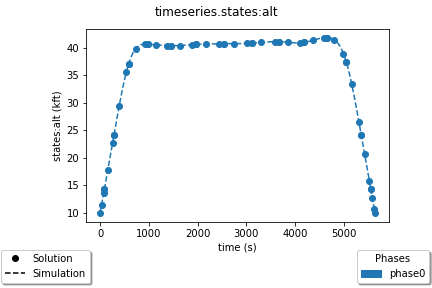

In [4]:
from IPython.display import Image
Image('plots/states_alt.png')

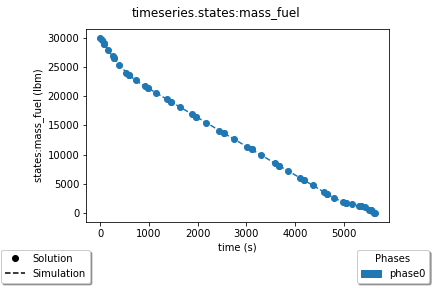

In [5]:
Image('plots/states_mass_fuel.png')

In [6]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('traj.phase0.timeseries.states:range', units='NM')[-1],
                  726.85, tolerance=1.0E-2)

0.0012864605045632806

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: C
:keyprefix: ex_commercial_aircraft-
```